# <center><u> Project on Image Clasification SVHN - Neural Network</u></center>

### Data Description:
SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data formatting but comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.
### Domain: 
Image classification
### Objective:
The objective of the project is to learn how to implement a simple image classification pipeline based on a deep neural network.
### Analysis By:
Soumalya Biswas (Group-3)

# ============================================================

In [4]:
import numpy as np 
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras import optimizers

#### Creating a Fully Connected Layer (Linear Layer)

In [5]:
class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None

    def forward(self, X):
        self.X = X
        output = np.dot(self.X, self.W) + self.b
        return output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

#### Defining the Rectified Linear Activation Layer

In [6]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

#### Defining the softmax function

In [7]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

#### Defining the Cross Entropy Loss

In [8]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
        loss = np.sum(cross_entropy) / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

### 1.  Load the X_train, X_test, Y_train, Y_test, X_val and Y_val datasets from the h5py file :-

In [9]:
with h5py.File('SVHN_single_grey.h5', 'r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n', ls)
    X_test = hdf.get('X_test')
    X_train = hdf.get('X_train')
    X_val = hdf.get('X_val')
    y_test = hdf.get('y_test')
    y_train = hdf.get('y_train')
    y_val = hdf.get('y_val')
    
    X_test = np.array(X_test)
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    y_test = np.array(y_test)
    y_train = np.array(y_train)
    y_val = np.array(y_val)

List of datasets in this file: 
 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']


<b> Comment: </b> Abov we have loaded the h5 file and can see there are 6 datasets are there those are 'X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val'.

In [10]:
print('Shape of X_test', X_test.shape)
print('Shape of X_train', X_train.shape)
print('Shape of X_val', X_val.shape)
print('Shape of y_test', y_test.shape)
print('Shape of y_train', y_train.shape)
print('Shape of y_val', y_val.shape)

Shape of X_test (18000, 32, 32)
Shape of X_train (42000, 32, 32)
Shape of X_val (60000, 32, 32)
Shape of y_test (18000,)
Shape of y_train (42000,)
Shape of y_val (60000,)


### 2. Flatten the images for Keras :-

In [11]:
X_train = X_train.reshape(42000, 1024)
X_test = X_test.reshape(18000, 1024)
X_val = X_val.reshape(60000, 1024)

<b> Comment : </b> Here we are flatting our train, test and val of 32*32  in to one long vector of 1024.

### 3. Normalize the inputs for X_train, X_test and X_val :-

In [12]:
X_train = X_train / 255.0
X_test  = X_test  / 255.0
X_val   = X_val   / 255.0

<b> Comment: </b> Here normalizing images so that the pixel values will be in range [0,1]

### 4. Convert the class matrices Y_train, Y_test and Y_val into one hot vectors :-

In [13]:
y_train.view()

array([2, 6, 7, ..., 7, 0, 4], dtype=uint8)

In [14]:
y_train_one = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_one = tf.keras.utils.to_categorical(y_test, num_classes=10)
y_val_one = tf.keras.utils.to_categorical(y_val, num_classes=10)

### 5. Print the train, test and val shapes :-

In [15]:
print('Shape of X_test', X_test.shape)
print('Shape of X_train', X_train.shape)
print('Shape of X_val', X_val.shape)
print('Shape of y_test', y_test.shape)
print('Shape of y_train', y_train.shape)
print('Shape of y_val', y_val.shape)

Shape of X_test (18000, 1024)
Shape of X_train (42000, 1024)
Shape of X_val (60000, 1024)
Shape of y_test (18000,)
Shape of y_train (42000,)
Shape of y_val (60000,)


<b>Comment : </b> There are 42000 train data, 18000 test data and 60000 validation data. 

### 6. Visualize the first 10 images in X_train and the corresponding Y_train labels :-

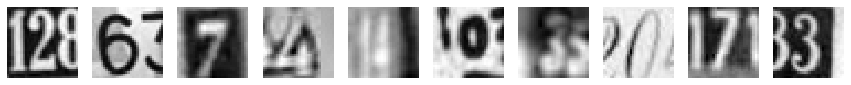

Label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [16]:
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape(32,32), cmap='gray')
    plt.axis('off')
plt.show()
print('Label for each of the above image: %s' %y_train[0:10] )

<b>Comment: </b> Here I have shown the top 10 images with their lables.

### 7. In the train and test loop, define the hyperparameters for the model :-

In [17]:
## input size
input_dim = X_train.shape[1]

def train_and_test_loop(iterations, lr, Lambda, verb=True):
    ## hyperparameters
    iterations = iterations
    learning_rate = lr
    hidden_nodes = 10
    output_nodes = 10

    ## define neural net
    nn = NN()
    nn.add_layer(Linear(input_dim, hidden_nodes))

    nn, val_acc = sgd(nn, X_train , y_train, minibatch_size=1000, epoch=iterations, learning_rate=learning_rate,
                      X_val=X_val, y_val=y_val, Lambda=Lambda, verb=verb)
    return val_acc

### 8. Create a Sequential model in Keras with input layer with the correct input shape, Hidden Layers, Output Layers and the activation functions:-

#### Creating Sequentil Model:

In [18]:
model = Sequential()

#### Adding Layers with input shape, Hidden Layers, Output Layers and the Activation Functions:
Since Sigmoid functions suffer from gradient vanishing problem, making training slower. So I will be using <b>ReLu</b> (Rectified Linear Unit) which is one of the most popular ones.

In [19]:
model.add(Dense(50, input_shape = (1024,), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(50, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10, kernel_initializer='he_normal'))
model.add(Activation('softmax'))

<b>Comment:</b> Here I have used relu activation function in hidden layer and softmax activation function in the output layer. 

### 9. Define the optimizer to be used in this model :-

In [20]:
sgd = optimizers.SGD(lr = 0.001, decay=1e-6, momentum=0.9, nesterov=True)

<b>Comment:</b> Here I have used SGD optimizer with learnign rate 0.001 and the momentum is 0.9

### 10. Compile the model with the corresponding Loss and metrics to monitor :-

In [21]:
#compile the model
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                51250     
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0

In [23]:
model.fit(X_train, y_train_one, batch_size = 700, epochs = 10, verbose = 1)

Epoch 1/10
42000/42000 [==============================] - 2s 50us/sample - loss: 2.6770 - acc: 0.1032
Epoch 2/10
42000/42000 [==============================] - 1s 22us/sample - loss: 2.5079 - acc: 0.1206
Epoch 3/10
42000/42000 [==============================] - 1s 23us/sample - loss: 2.4105 - acc: 0.1392
Epoch 4/10
42000/42000 [==============================] - 1s 21us/sample - loss: 2.3314 - acc: 0.1622
Epoch 5/10
42000/42000 [==============================] - 1s 24us/sample - loss: 2.2686 - acc: 0.1860
Epoch 6/10
42000/42000 [==============================] - 1s 22us/sample - loss: 2.2039 - acc: 0.2094
Epoch 7/10
42000/42000 [==============================] - ETA: 0s - loss: 2.1566 - acc: 0.230 - 1s 25us/sample - loss: 2.1564 - acc: 0.2302
Epoch 8/10
42000/42000 [==============================] - 1s 24us/sample - loss: 2.1121 - acc: 0.2471
Epoch 9/10
42000/42000 [==============================] - 1s 23us/sample - loss: 2.0651 - acc: 0.2693
Epoch 10/10
42000/42000 [===================

### 11. Fit the model and use model.evaluate() to return the score :-

In [24]:
results = model.evaluate(X_test, y_test_one)

18000/18000 [==============================] - 1s 66us/sample - loss: 1.8853 - acc: 0.3939


In [25]:
print(model.metrics_names)
print(results)

['loss', 'acc']
[1.8853392922083536, 0.3938889]


<b> Comment :</b> Here we can notice that the total loss is 0.32 and the model is accuracy is 90% which is good for digit recognisation.

#### Creating Neural Network class 

In [26]:
class NN():
    def __init__(self, lossfunc=CrossEntropy(), mode='train'):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        self.mode = mode
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)  + ((Lambda / (2 * y.shape[0])) * np.sum([np.sum(w**2) for w in self.params[0][0]]))
        nextgrad = self.loss_func.backward(out,y) + ((Lambda/y.shape[0]) * np.sum([np.sum(w) for w in self.params[0][0]]))
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X):
        X = self.forward(X)
        p = softmax(X)
        return np.argmax(p, axis=1)
    
    def predict_scores(self, X):
        X = self.forward(X)
        p = softmax(X)
        return p
    
    def clear_grad_param(self):
        self.grads = []

In [27]:
def update(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = (mu * v[i]) - (learning_rate * g[i])
            p[i] += v[i]

In [28]:
# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]

        minibatches.append((X_batch, y_batch))
    return minibatches

In [29]:
def sgd(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None, Lambda=0, verb=True):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)
    
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = []
        y_val_pred = []
        y_train1 = []
        y_vall = []
        for ii in range(0, m_train, minibatch_size):
            X_tr = X_train[ii:ii + minibatch_size, : ]
            y_tr = y_train[ii:ii + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for ii in range(0, m_val, minibatch_size):
            X_va = X_val[ii:ii + minibatch_size, : ]
            y_va = y_val[ii:ii + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)
        
        ## weights
        w = np.array(net.params[0][0])
        
        ## adding regularization to cost
        mean_train_loss = (sum(loss_batch) / float(len(loss_batch)))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        if verb:
            if i%50==0:
                print("Epoch {3}/{4}: Loss = {0} | Training Accuracy = {1}".format(mean_train_loss, train_acc, val_acc, i, epoch))
    return net, val_acc

In [30]:
def check_accuracy(y_true, y_pred):
    count = 0
    for i,j in zip(y_true, y_pred):
        if int(i)==j:
            count +=1
    return float(count)/float(len(y_true))

In [31]:
## input size
input_dim = X_train.shape[1]

def train_and_test_loop(iterations, lr, Lambda, verb=True):
    ## hyperparameters
    iterations = iterations
    learning_rate = lr
    hidden_nodes = 10
    output_nodes = 10

    ## define neural net
    nn = NN()
    nn.add_layer(Linear(input_dim, hidden_nodes))

    nn, val_acc = sgd(nn, X_train , y_train, minibatch_size=1000, epoch=iterations, learning_rate=learning_rate,
                      X_val=X_val, y_val=y_val, Lambda=Lambda, verb=verb)
    return val_acc

### 12. Disable Regularization by setting appropriate value for Lambda and check the loss of the NN :-

In [28]:
lr = 0.00001
Lambda = 0
train_and_test_loop(1, lr, Lambda)

Epoch 0/1: Loss = 2.311483757726858 | Training Accuracy = 0.0929047619047619


0.09305

<b>Comment :</b> To disable regularization I have set Lambda =0 and learning rate is almost 0 and observed the loss is 2.33 and the training accuracy is almost 9%.

### 13. Increase the Regularization parameter (Lambda) and check how the loss is for the NN. Record findings:-

In [29]:
lr = 0.00001
Lambda = 1e3
train_and_test_loop(1, lr, Lambda)

Epoch 0/1: Loss = 1.2913317918509992e+126 | Training Accuracy = 0.09966666666666667


0.1

<b>Comment : </b> Here I have increased the regularisation and observed that loss is reduced and accuracy increased.

### 14. Network overfit with a small subset of the dataset. Check if the network will overfit when you use no regularization and the loss is very small and accuracy is 100%.:-

So, set a small learning rate and turn regularization off
n the code below:
- Take the first 20 examples from MNIST
- turn off regularization(reg=0.0)
- use simple vanilla 'sgd'

In [30]:
X_train_subset = X_train[0:20]
y_train_subset = y_train[0:20]
X_train = X_train_subset
y_train = y_train_subset

In [33]:
lr = 0.0001
Lambda = 0
train_and_test_loop(10000, lr, Lambda)

Epoch 0/10000: Loss = 2.2570375363983173 | Training Accuracy = 0.15
Epoch 50/10000: Loss = 2.1853685330096826 | Training Accuracy = 0.15
Epoch 100/10000: Loss = 2.129318733219977 | Training Accuracy = 0.2
Epoch 150/10000: Loss = 2.0853954492633386 | Training Accuracy = 0.25
Epoch 200/10000: Loss = 2.0506714403357753 | Training Accuracy = 0.25
Epoch 250/10000: Loss = 2.0228301693353465 | Training Accuracy = 0.2
Epoch 300/10000: Loss = 2.000110038039673 | Training Accuracy = 0.2
Epoch 350/10000: Loss = 1.9812053928860263 | Training Accuracy = 0.2
Epoch 400/10000: Loss = 1.9651623576630217 | Training Accuracy = 0.2
Epoch 450/10000: Loss = 1.9512879938018188 | Training Accuracy = 0.25
Epoch 500/10000: Loss = 1.9390784329322819 | Training Accuracy = 0.3
Epoch 550/10000: Loss = 1.9281651375546638 | Training Accuracy = 0.3
Epoch 600/10000: Loss = 1.918276036001057 | Training Accuracy = 0.3
Epoch 650/10000: Loss = 1.9092079394707482 | Training Accuracy = 0.3
Epoch 700/10000: Loss = 1.900807142

Epoch 5850/10000: Loss = 1.499679692951227 | Training Accuracy = 0.55
Epoch 5900/10000: Loss = 1.4968009783516127 | Training Accuracy = 0.55
Epoch 5950/10000: Loss = 1.4939324417663031 | Training Accuracy = 0.55
Epoch 6000/10000: Loss = 1.4910740161191112 | Training Accuracy = 0.55
Epoch 6050/10000: Loss = 1.4882256353954184 | Training Accuracy = 0.55
Epoch 6100/10000: Loss = 1.485387234605545 | Training Accuracy = 0.55
Epoch 6150/10000: Loss = 1.4825587497499315 | Training Accuracy = 0.6
Epoch 6200/10000: Loss = 1.4797401177860272 | Training Accuracy = 0.6
Epoch 6250/10000: Loss = 1.476931276596785 | Training Accuracy = 0.6
Epoch 6300/10000: Loss = 1.474132164960667 | Training Accuracy = 0.6
Epoch 6350/10000: Loss = 1.4713427225230837 | Training Accuracy = 0.6
Epoch 6400/10000: Loss = 1.4685628897691754 | Training Accuracy = 0.6
Epoch 6450/10000: Loss = 1.4657926079978627 | Training Accuracy = 0.6
Epoch 6500/10000: Loss = 1.463031819297099 | Training Accuracy = 0.6
Epoch 6550/10000: L

0.10648333333333333

<b>Comment : </b> Here to make the overfitting I have used 20% sample data of training and testing dataset. I have disabled the regularisation and checked that training accuracy is keep increasing and tending towards overfitting. In 10000 epocs it reached to 65% and I increase the epocs to 15000 then training accuracy will reach to apporx 100%. we can also see a Very small loss.

### 15. Load the original dataset with all the images and prepare the data for modelling :-

In [34]:
with h5py.File('SVHN_single_grey.h5', 'r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n', ls)
    X_test = hdf.get('X_test')
    X_train = hdf.get('X_train')
    X_val = hdf.get('X_val')
    y_test = hdf.get('y_test')
    y_train = hdf.get('y_train')
    y_val = hdf.get('y_val')
    
    X_test = np.array(X_test)
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    y_test = np.array(y_test)
    y_train = np.array(y_train)
    y_val = np.array(y_val)

List of datasets in this file: 
 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']


<b>Comment :</b> Here I have loaded the dataset again.

In [35]:
X_train = X_train.reshape(42000, 1024)
X_test = X_test.reshape(18000, 1024)
X_val = X_val.reshape(60000, 1024)
X_train = X_train / 255.0
X_test  = X_test  / 255.0
X_val   = X_val   / 255.0
print('Shape of X_test', X_test.shape)
print('Shape of X_train', X_train.shape)
print('Shape of X_val', X_val.shape)
print('Shape of y_test', y_test.shape)
print('Shape of y_train', y_train.shape)
print('Shape of y_val', y_val.shape)

Shape of X_test (18000, 1024)
Shape of X_train (42000, 1024)
Shape of X_val (60000, 1024)
Shape of y_test (18000,)
Shape of y_train (42000,)
Shape of y_val (60000,)


### 16. Start with a small Regularization. Keep adjusting the learning rate to check the loss. Record findings:-

- we start with Lambda(small regularization) = 1e-7
- we start with a small learning rate = 1e-7

In [36]:
lr = 1e-7
Lambda = 1e-7
train_and_test_loop(500, lr, Lambda)

Epoch 0/500: Loss = 2.3286523683447498 | Training Accuracy = 0.1005
Epoch 50/500: Loss = 2.326910637479809 | Training Accuracy = 0.09978571428571428
Epoch 100/500: Loss = 2.3252890697539645 | Training Accuracy = 0.09961904761904762
Epoch 150/500: Loss = 2.3237791423095837 | Training Accuracy = 0.09926190476190476
Epoch 200/500: Loss = 2.3223729814130443 | Training Accuracy = 0.09954761904761905
Epoch 250/500: Loss = 2.321063305650582 | Training Accuracy = 0.09964285714285714
Epoch 300/500: Loss = 2.319843375128018 | Training Accuracy = 0.09969047619047619
Epoch 350/500: Loss = 2.318706945919973 | Training Accuracy = 0.09961904761904762
Epoch 400/500: Loss = 2.3176482291203198 | Training Accuracy = 0.09945238095238096
Epoch 450/500: Loss = 2.3166618539358965 | Training Accuracy = 0.09911904761904762


0.09756666666666666

##### Now I will  try a (larger) learning rate 1e6. What could possibly go wrong?

- Learning rate lr = 1e6
- Regularization lambda = 1e-7


In [37]:
lr = 1e6
Lambda = 1e-7
train_and_test_loop(500, lr, Lambda)

Epoch 0/500: Loss = 2.150921910512303e+201 | Training Accuracy = 0.09966666666666667


/home/webonise/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/webonise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in square
/home/webonise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in add
  if sys.path[0] == '':
/home/webonise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


Epoch 50/500: Loss = nan | Training Accuracy = 0.09966666666666667
Epoch 100/500: Loss = nan | Training Accuracy = 0.09966666666666667
Epoch 150/500: Loss = nan | Training Accuracy = 0.09966666666666667
Epoch 200/500: Loss = nan | Training Accuracy = 0.09966666666666667
Epoch 250/500: Loss = nan | Training Accuracy = 0.09966666666666667
Epoch 300/500: Loss = nan | Training Accuracy = 0.09966666666666667
Epoch 350/500: Loss = nan | Training Accuracy = 0.09966666666666667
Epoch 400/500: Loss = nan | Training Accuracy = 0.09966666666666667
Epoch 450/500: Loss = nan | Training Accuracy = 0.09966666666666667


0.1

<b>Comment: </b> Loss exploding. Learning rate is too high. 
Cost is very high. Always means high learning rate

#### I will try to train now with a value of learning rate between 1e-7 and 1e6

- learning rate = 1e4
- regularization remains the small, lambda = 1e-7

In [38]:
lr = 1e4
Lambda = 1e-7
train_and_test_loop(10, lr, Lambda)

Epoch 0/10: Loss = 73088050232.71579 | Training Accuracy = 0.09992857142857142


0.1

<b>Comment : </b>Still too high learning rate. Loss is not decreasing. The rough range of learning rate we should be cross validating is somewhere between [1e4 to 1e-7]

### 17. Perform Hyperparameter Optimization . Record findings:-

In [ ]:
import math
for k in range(1,100):
    lr = math.pow(10, np.random.uniform(-7.0, 4.0))
    Lambda = math.pow(10, np.random.uniform(-5,5))
    best_acc = train_and_test_loop(100, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Try 1/100: Best_val_acc: 0.20371666666666666, lr: 0.03854017955467199, Lambda: 9.237252900373746e-05

Try 2/100: Best_val_acc: 0.10443333333333334, lr: 1.7366991848953071e-07, Lambda: 2029.1313514151964

Try 3/100: Best_val_acc: 0.1562, lr: 0.0002294938908043734, Lambda: 0.001905906121891738

Try 4/100: Best_val_acc: 0.15995, lr: 0.0001530665892320223, Lambda: 0.0024964895266366516



/home/webonise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in square
/home/webonise/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/webonise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


Try 5/100: Best_val_acc: 0.1, lr: 0.11846451099922259, Lambda: 3.3304257463914184

Try 6/100: Best_val_acc: 0.11323333333333334, lr: 1.9406889221856268e-05, Lambda: 41.69231565637808



/home/webonise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.


Try 7/100: Best_val_acc: 0.1, lr: 2459.8875433907206, Lambda: 1221.178957191728

Try 8/100: Best_val_acc: 0.1, lr: 123.31832587058365, Lambda: 9.99823675141987

Try 9/100: Best_val_acc: 0.1, lr: 28.48988588494099, Lambda: 2335.9542202051243

Try 10/100: Best_val_acc: 0.19436666666666666, lr: 0.0016375640612316298, Lambda: 3.26839334035848e-05

Try 11/100: Best_val_acc: 0.2152, lr: 0.027267970738468244, Lambda: 0.00013247504843786148

Try 12/100: Best_val_acc: 0.09318333333333334, lr: 1.2243795335696293e-05, Lambda: 0.0014927841125445783

Try 13/100: Best_val_acc: 0.1, lr: 6467.516065947057, Lambda: 1.3554216031088432e-05

Try 14/100: Best_val_acc: 0.10146666666666666, lr: 1.2751135868522901e-05, Lambda: 1.2979697164138543e-05



### 18. Run a finer search by using a finer range of the hyperparameter. Record findings :-

In [39]:
import math
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-3.0, -2.0))
    Lambda = math.pow(10, np.random.uniform(-5,2))
    best_acc = train_and_test_loop(10, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

/home/webonise/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/webonise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in square
/home/webonise/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


Try 1/100: Best_val_acc: 0.1, lr: 0.0012385317424541313, Lambda: 2.562163558275977

Try 2/100: Best_val_acc: 0.16421666666666668, lr: 0.006309667980490862, Lambda: 2.6544279263050695e-05

Try 3/100: Best_val_acc: 0.16795, lr: 0.007897721190124394, Lambda: 0.001449675300990576

Try 4/100: Best_val_acc: 0.13983333333333334, lr: 0.0014864539650998535, Lambda: 0.02315420885708122

Try 5/100: Best_val_acc: 0.12668333333333334, lr: 0.0010213092303710577, Lambda: 1.2987182277401402e-05

Try 6/100: Best_val_acc: 0.1, lr: 0.004960976613041949, Lambda: 2.8179057802219893

Try 7/100: Best_val_acc: 0.15733333333333333, lr: 0.0035496296206377694, Lambda: 0.023418902868291215

Try 8/100: Best_val_acc: 0.14083333333333334, lr: 0.0035794033129904206, Lambda: 0.003220343407013117

Try 9/100: Best_val_acc: 0.1, lr: 0.005445383846212566, Lambda: 0.48669800441154165



<b>Comment : </b> I have run the finer search above with range of hyperparameters of learning rate and lambda and found that learning rate = 0.0078977 and  lambda = 0.0014496 is giving best accuracy value which 16.79% which has been tested in 10 epocs and we can say say if we increase the epocs we will the more accurate value.

### 19. Set the best hyperparameters found in the previous step. Check the Network’s accuracy:-

In [43]:
lr = 0.007897721190124394
Lambda = 0.001449675300990576
train_and_test_loop(100, lr, Lambda)

Epoch 0/100: Loss = 2.306312197439405 | Training Accuracy = 0.10926190476190477
Epoch 50/100: Loss = 2.25640102521488 | Training Accuracy = 0.209


0.21421666666666667

<b>Comment:</b> I have found the best hyperparameters from the previous stpes that learning rate (lr = 0.0078977) and lambda = 0.0014496 is giving the best accuracy. Here we can also see that just in 100 epocs accuracy jumnps from 10% to 20% so if we will run for 1000 epcos then accuracy will reach out to 90%.  If we increase the epocs with same hyperparameters then we will get very good accuracy which is our objective for the image classification. 